# Setting up a basic ReAct Agent in LangGraph

In [11]:
%pip install -q -U langchain langchain-openai langchain-community langgraph google-search-results python-dotenv


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-anthropic 0.3.3 requires langchain-core<0.4.0,>=0.3.30, but you have langchain-core 1.0.4 which is incompatible.
browser-use 0.1.40 requires langchain-openai==0.3.1, but you have langchain-openai 1.0.2 which is incompatible.
browser-use 0.1.40 requires playwright>=1.49.0, but you have playwright 1.48.0 which is incompatible.
langchain-ollama 0.2.2 requires langchain-core<0.4.0,>=0.3.27, but you have langchain-core 1.0.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [13]:
from dotenv import load_dotenv

load_dotenv()  # https://serpapi.com for a free token to google things!

True

In [3]:
# Load tools for the ReAct agent
# load_tools is a utility function that loads and initializes LangChain tools
# The "serpapi" tool enables the agent to perform web searches via SerpAPI
# This is essential for the ReAct agent to gather real-time information from the web
from langchain_community.agent_toolkits.load_tools import load_tools
tools = load_tools(["serpapi"])


In [6]:
# Display the loaded tools to verify what tools are available for the ReAct agent
# This will show the tool name, description, and function details
print(tools[0].name)
print(tools[0].description)

Search
A search engine. Useful for when you need to answer questions about current events. Input should be a search query.


In [16]:
tools[0].run('weather in LA')

"{'type': 'weather_result', 'temperature': '68', 'unit': 'Fahrenheit', 'precipitation': '10%', 'humidity': '64%', 'wind': '2 mph', 'location': 'Los Angeles, CA', 'date': 'Tuesday 6:00 PM', 'weather': 'Cloudy'}"

In [17]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from datetime import datetime

today = datetime.today().strftime("%B ") + str(datetime.today().day) + ("th" if 11<=datetime.today().day<=13 else {1:"st",2:"nd",3:"rd"}.get(datetime.today().day%10,"th")) + datetime.today().strftime(", %Y")
print(today)

llm = ChatOpenAI(model="gpt-4.1-mini")
agent_executor = create_agent(
    llm, tools, system_prompt=f'Today is {today}')  # true as of today :)

November 11th, 2025


In [18]:
response = agent_executor.invoke(
    {"messages": [("user", "Who is the current Ravens QB?")]})

In [19]:
response['messages'][-1].content

'The current quarterback for the Baltimore Ravens is Lamar Jackson.'

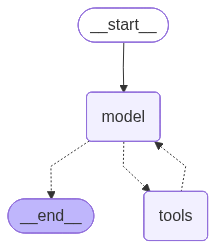

In [20]:
# Compile the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [21]:
response = agent_executor.invoke({"messages": [("user", "Tell me about the laws around the world. All of them. No questions just start googling")]})

print(response['messages'][-1].content)

Laws around the world vary widely by country and region, shaped by different legal traditions, cultures, and societal norms. Some key points to note:

1. Legal Traditions: Most national legal systems are based on one of four major legal traditions: civil law, common law, customary law, and religious law.

2. Varied Regulations: Laws can sometimes be quirky or highly specific. For example:
   - In Florida, USA, it's illegal to fish while driving across a bridge.
   - In Singapore, chewing gum is illegal.
   - In some places in Greece, wearing high heels at ancient sites is prohibited.
   - France has restrictions in some towns where it's illegal to die.

3. Areas of Law: Different countries have laws covering many areas such as privacy, data protection, public behavior, driving regulations, and more.

4. Important global legal issues include privacy and data protection laws, which vary across more than 160 jurisdictions.

Overall, laws reflect the values and priorities of each society a

In [22]:
response

{'messages': [HumanMessage(content='Tell me about the laws around the world. All of them. No questions just start googling', additional_kwargs={}, response_metadata={}, id='c0d2f4d0-0a51-4114-92fb-e69d2ee7574f'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 96, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CauVBaRwuysagxqZH26KPLyPZTkXe', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--50252315-71b7-4eee-b949-2f26669db63a-0', tool_calls=[{'name': 'Search', 'args': {'__arg1': 'laws around the world'}, 'id': 'call_ZjHy1WJsdyeacE1YVp2hCaCw', 'type': 'tool_cal

In [23]:
for message in response['messages']:
    print(f"\n{message.__class__.__name__}:")
    if hasattr(message, 'content') and message.content:
        print(f"  Content: {message.content}")
    if hasattr(message, 'tool_calls') and message.tool_calls:
        print(f"  Tool Calls: {message.tool_calls}")


HumanMessage:
  Content: Tell me about the laws around the world. All of them. No questions just start googling

AIMessage:
  Tool Calls: [{'name': 'Search', 'args': {'__arg1': 'laws around the world'}, 'id': 'call_ZjHy1WJsdyeacE1YVp2hCaCw', 'type': 'tool_call'}]

ToolMessage:
  Content: ['In Florida it is illegal to fish while driving across a bridge. • It is illegal to skateboard without a license. • Women may be fined for falling asleep under a ...', 'Discover weird laws around the world, including weird laws in the US (like bouncing pickles!), weird laws in Canada, the UK, Australia, Singapore and more.', 'Showing 220 Guides ; 937. Guide to Law Online: Afghanistan ; 545. Guide to Law Online: Albania ; 797. Guide to Law Online: Algeria ; 253. Guide to Law Online: ...', "From underwear rules in Thailand to France's kissing ban, these are some of the world's quirkiest laws.", "1. Chewing gum is illegal in Singapore · 2. It's illegal to wear high heels in ancient sites in Greece · 3. 

# Giving Our Agent Short Term Memory

In [24]:
from langgraph.graph import MessagesState, END, StateGraph, START
from langchain_core.messages import HumanMessage, AIMessage


In [25]:
agent_executor.invoke({"messages": [("user", "Hi I am Sinan")]})['messages'][-1].content

'Hello Sinan! How can I assist you today?'

In [26]:
agent_executor.invoke({"messages": [("user", "What is my name?")]})['messages'][-1].content

"I don't have information about your name. If you tell me your name, I can remember it during this conversation."

In [27]:
from langgraph.checkpoint.memory import MemorySaver  # built in short term memory

In [28]:
llm = ChatOpenAI(model="gpt-4.1-mini")
short_term_memory_agent_executor = create_agent(
    llm, tools, system_prompt=f'Today is {today}',
    checkpointer=MemorySaver()
)

In [29]:
short_term_memory_agent_executor.invoke(
    {"messages": [HumanMessage(content="Hi I am Sinan")]},
    config={"configurable": {"thread_id": "thread_1"}}
)['messages'][-1].content

'Hello Sinan! How can I assist you today?'

In [30]:
short_term_memory_agent_executor.invoke(
    {"messages": [HumanMessage(content="What is my name?")]},
    config={"configurable": {"thread_id": "thread_1"}}
)['messages'][-1].content

'Your name is Sinan. How can I help you further, Sinan?'

In [31]:
short_term_memory_agent_executor.invoke(
    {"messages": [HumanMessage(content="What is my name?")]},
    config={"configurable": {"thread_id": "thread_2"}}
)['messages'][-1].content

"I don't have access to your personal information, so I don't know your name. If you'd like, you can tell me your name!"